<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-description" data-toc-modified-id="Basic-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic description</a></span></li><li><span><a href="#Date-distribution" data-toc-modified-id="Date-distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Date distribution</a></span></li><li><span><a href="#Item-frequencies" data-toc-modified-id="Item-frequencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Item frequencies</a></span></li><li><span><a href="#Item-price-distribution" data-toc-modified-id="Item-price-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Item price distribution</a></span></li><li><span><a href="#Number-of-sales-and-simple-predictions" data-toc-modified-id="Number-of-sales-and-simple-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Number of sales and simple predictions</a></span></li><li><span><a href="#Shop-frequencies" data-toc-modified-id="Shop-frequencies-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Shop frequencies</a></span></li><li><span><a href="#Category-frequencies" data-toc-modified-id="Category-frequencies-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Category frequencies</a></span></li><li><span><a href="#Time-Series-Plots" data-toc-modified-id="Time-Series-Plots-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Time Series Plots</a></span><ul class="toc-item"><li><span><a href="#City/shop-over-time" data-toc-modified-id="City/shop-over-time-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>City/shop over time</a></span></li><li><span><a href="#Category-over-time" data-toc-modified-id="Category-over-time-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Category over time</a></span></li></ul></li><li><span><a href="#Shop-vs-Category" data-toc-modified-id="Shop-vs-Category-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Shop vs Category</a></span></li><li><span><a href="#Test-data-exploration" data-toc-modified-id="Test-data-exploration-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Test data exploration</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

First, I'm going to extract some more general categories from the `shop_name` and the `item_category_name` columns. Then join these support tables to the train and test dataframes.

In [2]:
TRAIN_PATH = '/kaggle/input/competitive-data-science-predict-future-sales/' 
items = pd.read_csv(TRAIN_PATH+'items.csv')
categories = pd.read_csv(TRAIN_PATH+'item_categories.csv')
shops = pd.read_csv(TRAIN_PATH+'shops.csv')
sales = pd.read_csv(TRAIN_PATH+'sales_train.csv')
test_df = pd.read_csv(TRAIN_PATH+'/test.csv')

shops['city'] = shops['shop_name'].str.split(n=1, expand=True)[0]
other = shops['city'].isin(['Цифровой', 'Интернет-магазин', 'Выездная'])
shops.loc[other, 'city'] = 'Other'
shops.loc[shops['city'].str.contains('Якутск'), 'city'] = 'Якутск'

categories['primary_category'] = categories['item_category_name'].str.split(' -', n=1, expand=True)[0]
categories.loc[categories['primary_category'].str.startswith('Чистые носители'), 'primary_category'] = 'Чистые носители'
categories.loc[categories['primary_category'].str.startswith('Карты оплаты'), 'primary_category'] = 'Карты оплаты'

sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
sales['revenue'] = sales['item_price'] * sales['item_cnt_day']

train_df = (sales.merge(shops, on='shop_id')
                 .merge(items, on='item_id')
                 .merge(categories, on='item_category_id')
                 )

test_df = (test_df.merge(shops, on='shop_id')
                  .merge(items, on='item_id')
                  .merge(categories, on='item_category_id')
                  )

In [3]:
train_df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-01-02               0       25    22154       999.0           1.0   
2 2013-01-03               0       25    22154       999.0           1.0   
3 2013-01-20               0       25    22154       999.0           1.0   
4 2013-01-23               0       25    22154       999.0           1.0   

   revenue               shop_name       city          item_name  \
0    999.0  Ярославль ТЦ "Альтаир"  Ярославль  ЯВЛЕНИЕ 2012 (BD)   
1    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   
2    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   
3    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   
4    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   

   item_category_id item_category_name primary_category  
0                37     Кино - Blu-Ray             Кино  
1                37     Кино - Blu-Ray             Кино  
2                37     Кино - Blu-Ray             Кино  
3                37     Кино - Blu-Ray             Кино  
4                37     Кино - Blu-Ray             Кино

In [4]:
train_df.shape, test_df.shape

((2935849, 13), (214200, 9))

## Basic description

In [5]:
train_df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-01-02               0       25    22154       999.0           1.0   
2 2013-01-03               0       25    22154       999.0           1.0   
3 2013-01-20               0       25    22154       999.0           1.0   
4 2013-01-23               0       25    22154       999.0           1.0   

   revenue               shop_name       city          item_name  \
0    999.0  Ярославль ТЦ "Альтаир"  Ярославль  ЯВЛЕНИЕ 2012 (BD)   
1    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   
2    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   
3    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   
4    999.0     Москва ТРК "Атриум"     Москва  ЯВЛЕНИЕ 2012 (BD)   

   item_category_id item_category_name primary_category  
0                37     Кино - Blu-Ray             Кино  
1                37     Кино - Blu-Ray             Кино  
2                37     Кино - Blu-Ray             Кино  
3                37     Кино - Blu-Ray             Кино  
4                37     Кино - Blu-Ray             Кино

In [6]:
train_df.shape

(2935849, 13)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   revenue             float64       
 7   shop_name           object        
 8   city                object        
 9   item_name           object        
 10  item_category_id    int64         
 11  item_category_name  object        
 12  primary_category    object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 313.6+ MB


In [8]:
train_df.loc[:, ~train_df.columns.str.contains('_id')].describe()

date_block_num    item_price  item_cnt_day       revenue
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  8.908532e+02  1.242641e+00  1.157732e+03
std      9.422988e+00  1.729800e+03  2.618834e+00  5.683604e+03
min      0.000000e+00 -1.000000e+00 -2.200000e+01 -6.897000e+04
25%      7.000000e+00  2.490000e+02  1.000000e+00  2.490000e+02
50%      1.400000e+01  3.990000e+02  1.000000e+00  4.490000e+02
75%      2.300000e+01  9.990000e+02  1.000000e+00  1.078200e+03
max      3.300000e+01  3.079800e+05  2.169000e+03  1.829990e+06

In [9]:
train_df.nunique()

date                   1034
date_block_num           34
shop_id                  60
item_id               21807
item_price            19993
item_cnt_day            198
revenue               24771
shop_name                60
city                     29
item_name             21807
item_category_id         84
item_category_name       84
primary_category         18
dtype: int64

In [10]:
train_df.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
revenue               0
shop_name             0
city                  0
item_name             0
item_category_id      0
item_category_name    0
primary_category      0
dtype: int64

## Date distribution

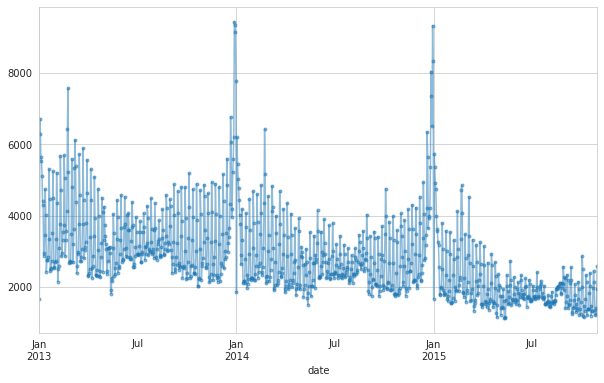

In [11]:
train_df.groupby('date').size().plot(marker='.', alpha=0.5);

There is some seasonality patterns

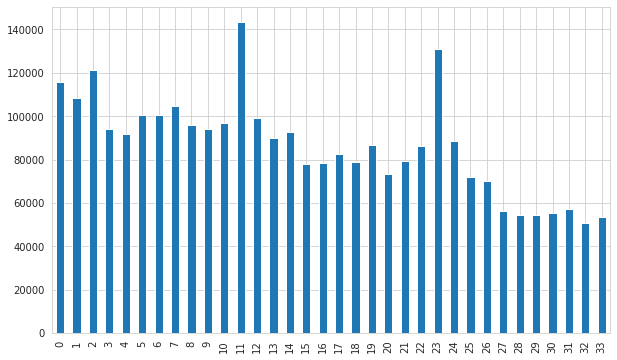

In [12]:
train_df['date_block_num'].value_counts().sort_index().plot(kind='bar');

## Item frequencies

In [13]:
train_df['item_id'].value_counts().describe()

count    21807.000000
mean       134.628743
std        406.938186
min          1.000000
25%          6.000000
50%         32.000000
75%        119.000000
max      31340.000000
Name: item_id, dtype: float64

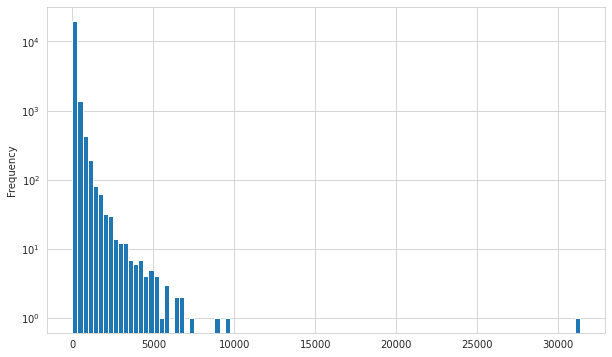

In [14]:
train_df['item_id'].value_counts().plot(kind='hist', logy=True, bins=100);

In [15]:
train_df['item_name'].value_counts().head(10)

Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                    31340
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.                            9408
Прием денежных средств для 1С-Онлайн                                                      9067
Diablo III [PC, Jewel, русская версия]                                                    7479
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box     6853
World of Warcraft. Карта оплаты игрового времени (online) (рус.в.) (60 дней) (Jewel)      6602
Grand Theft Auto V [PS3, русские субтитры]                                                6475
Call of Duty: Black Ops II [PС, Jewel, русская версия]                                    6320
Minecraft [Xbox 360, английская версия]                                                   5811
Grand Theft Auto V [Xbox 360, русские субтитры]                                           5805
Name: item_name, dtype: int64

The most frequent item is a plastic bag. Looks realistic

## Item price distribution

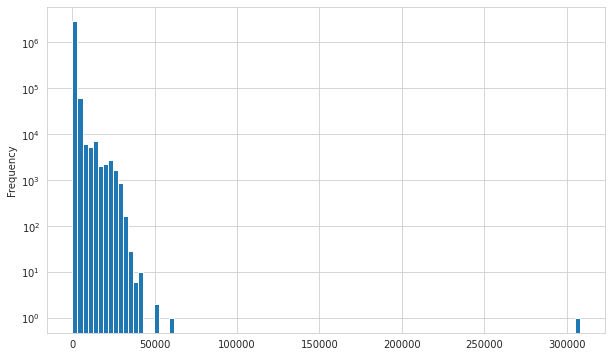

In [16]:
train_df['item_price'].plot(kind='hist', logy=True, bins=100);

In [17]:
train_df[train_df['item_price'] >= 40000] 

date  date_block_num  shop_id  item_id  item_price  \
2105018 2013-10-24               9       12     7238     42000.0   
2105022 2013-12-13              11       12     6066    307980.0   
2105039 2014-11-20              22       12    14173     40900.0   
2105041 2015-01-29              24       12     7241     49782.0   
2269597 2014-03-20              14       25    13199     50999.0   
2862907 2015-10-20              33       22    13403     42990.0   
2862908 2015-10-22              33       18    13403     41990.0   
2862909 2015-10-22              33       28    13403     40991.0   
2862910 2015-10-20              33        3    13403     42990.0   
2862911 2015-10-20              33       12    13403     41990.0   
2862912 2015-10-29              33       12    13403     42990.0   
2862914 2015-10-23              33       42    13403     42990.0   
2862917 2015-10-20              33       38    13403     41990.0   
2899483 2013-09-17               8       12    11365     59200.0   

         item_cnt_day   revenue                        shop_name        city  \
2105018           1.0   42000.0              Интернет-магазин ЧС       Other   
2105022           1.0  307980.0              Интернет-магазин ЧС       Other   
2105039           1.0   40900.0              Интернет-магазин ЧС       Other   
2105041           1.0   49782.0              Интернет-магазин ЧС       Other   
2269597           1.0   50999.0              Москва ТРК "Атриум"      Москва   
2862907           1.0   42990.0               Москва Магазин С21      Москва   
2862908           1.0   41990.0             Красноярск ТЦ "Июнь"  Красноярск   
2862909           1.0   40991.0  Москва ТЦ "МЕГА Теплый Стан" II      Москва   
2862910           1.0   42990.0   Балашиха ТРК "Октябрь-Киномир"    Балашиха   
2862911           1.0   41990.0              Интернет-магазин ЧС       Other   
2862912           1.0   42990.0              Интернет-магазин ЧС       Other   
2862914           1.0   42990.0           СПб ТК "Невский Центр"         СПб   
2862917           1.0   41990.0                   Омск ТЦ "Мега"        Омск   
2899483           1.0   59200.0              Интернет-магазин ЧС       Other   

                                                 item_name  item_category_id  \
2105018        UserGate Proxy & Firewall 6.X до 100 сессий                75   
2105022                               Radmin 3  - 522 лиц.                75   
2105039   Лицензия 1С-Битрикс: Управление сайтом - Эксперт                75   
2105041  UserGate Proxy & Firewall 6.X с модулем фильтр...                75   
2269597            Коллекционные шахматы (Властелин Колец)                69   
2862907  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862908  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862909  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862910  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862911  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862912  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862914  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2862917  Комплект "Microsoft Xbox One 1TB  Limited Edit...                16   
2899483                                     Доставка (EMS)                 9   

                   item_category_name primary_category  
2105018  Программы - Для дома и офиса        Программы  
2105022  Программы - Для дома и офиса        Программы  
2105039  Программы - Для дома и офиса        Программы  
2105041  Программы - Для дома и офиса        Программы  
2269597            Подарки - Сувениры          Подарки  
2862907    Игровые консоли - XBOX ONE  Игровые консоли  
2862908    Игровые консоли - XBOX ONE  Игровые консоли  
2862909    Игровые консоли - XBOX ONE  Игровые консоли  
2862910    Игровые консоли - XBOX ONE  Игровые консоли  
2862911    Игровые ко

Row id=2105022 looks strange. It is definitely an outlier by price, but we can see "522 licenses" in its name. Maybe it was a system glitch or something. Let's examine

In [18]:
train_df.loc[train_df['item_name'].str.contains('Radmin 3'), 'item_name'].value_counts()

Radmin 3  - 1 лиц.      33
Radmin 3  - 522 лиц.     1
Name: item_name, dtype: int64

In [19]:
items[items['item_name'].str.contains('Radmin 3')]

item_name  item_id  item_category_id
6065    Radmin 3  - 1 лиц.     6065                75
6066  Radmin 3  - 522 лиц.     6066                75

Let's fix

In [20]:
outlier = train_df.iloc[2105022].copy()
outlier.update(items.iloc[6065])
outlier.update({'item_price': outlier.item_price/522, 'item_cnt_day': 522})
train_df.iloc[2105022] = outlier
train_df.iloc[2105022]

date                           2013-12-13 00:00:00
date_block_num                                  11
shop_id                                         12
item_id                                       6065
item_price                                   590.0
item_cnt_day                                 522.0
revenue                                   307980.0
shop_name                      Интернет-магазин ЧС
city                                         Other
item_name                       Radmin 3  - 1 лиц.
item_category_id                                75
item_category_name    Программы - Для дома и офиса
primary_category                         Программы
Name: 2105022, dtype: object

## Number of sales and simple predictions

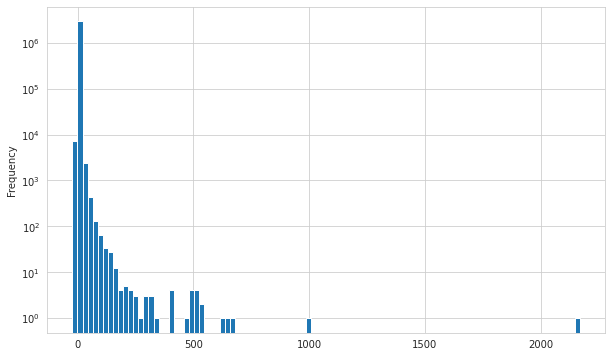

In [21]:
train_df['item_cnt_day'].plot(kind='hist', logy=True, bins=100);

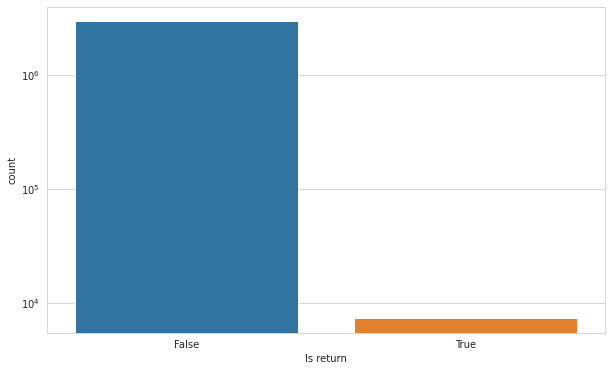

In [22]:
plt.yscale('log')
sns.countplot(x=(train_df['item_cnt_day'] < 0))
plt.xlabel('Is return');

Distribution of sales for shop-item pairs in the last month of training data (October 2015)

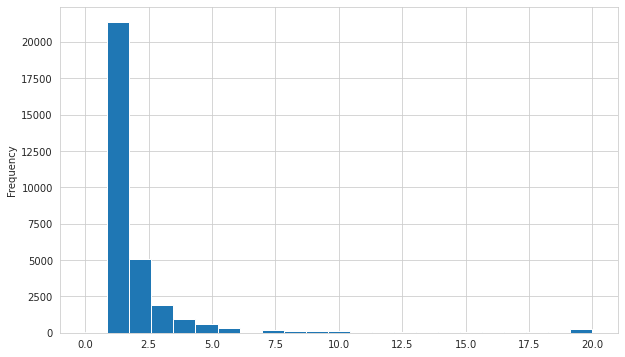

In [23]:
oct15 = (train_df[train_df.date >= '2015-10-01']
                 .groupby(['shop_id', 'item_id'])
                 .agg({'item_cnt_day': 'sum'})
                 .rename(columns={'item_cnt_day': 'item_cnt_month'})
                 .reset_index()
                 )

# Make a "naive prediction"
pred = test_df.merge(oct15, how='left', on=['shop_id', 'item_id'])
pred['item_cnt_month'] = pred['item_cnt_month'].fillna(0).clip(0, 20)
pred.to_csv('naive.csv', index=False, columns=['ID', 'item_cnt_month'])  # 1.16777 Public LB

oct15['item_cnt_month'].clip(0, 20).plot.hist(bins=23);

Distribution of average monthly sales for shop-item pairs (not very informative, as we will see later, distribution changes over the time)

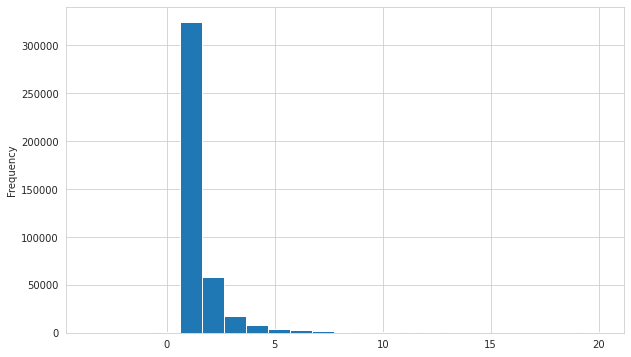

In [24]:
monthly_shop_mean = train_df.groupby(['date_block_num', 'item_name', 'shop_name'])['item_cnt_day'].sum().groupby(['item_name', 'shop_name']).mean()
top_sales = monthly_shop_mean > 20
monthly_shop_mean[top_sales] = 20

pred = test_df.merge(monthly_shop_mean, how='left', on=['shop_name', 'item_name'])
pred['item_cnt_month'] = pred['item_cnt_day'].fillna(0).clip(0, 20)
pred.to_csv('monthly_shop_mean.csv', index=False, columns=['ID', 'item_cnt_month'])  # 1.79137 on Public LB

monthly_shop_mean.plot.hist(bins=23);

In [25]:
monthly_shop_mean[top_sales]

item_name                                             shop_name                      
007: КООРДИНАТЫ «СКАЙФОЛЛ»                            !Якутск Орджоникидзе, 56 фран      20.0
1812: УЛАНСКАЯ БАЛЛАДА                                Москва ТЦ "МЕГА Теплый Стан" II    20.0
1С:Бухгалтерия 8. Учебная версия. Издание 7.          Москва Магазин С21                 20.0
1С:Бухгалтерия 8. Учебная версия. Издание 8.          Москва Магазин С21                 20.0
1С:Деньги 8 Электронная версия [PC, Цифровая версия]  Цифровой склад 1С-Онлайн           20.0
                                                                                         ... 
Энциклопедия Мир Ведьмака                             Выездная Торговля                  20.0
                                                      Интернет-магазин ЧС                20.0
                                                      Москва "Распродажа"                20.0
                                                      Москва ТРК "Ат

Distribution of exponential weighted average monthly sales for shop-item pairs. For alpha=0.9 we can think about EWA as a naive prediction with a little past impact. In fact, it gives the best result on public LB. Parameter alpha can be tuned to create a better baseline, or get an intuition about how much past impacts the future.

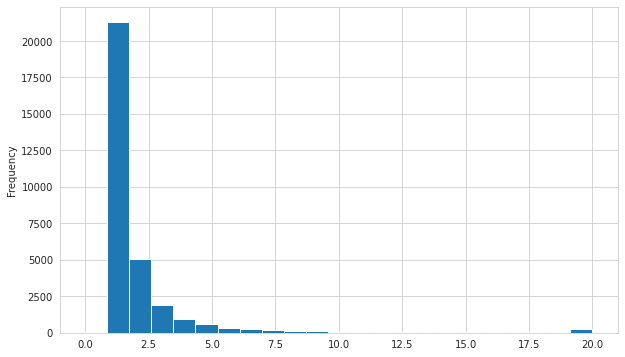

In [26]:
monthly_shop_ewmean = train_df.groupby(['date_block_num', 'item_name', 'shop_name'])['item_cnt_day'].sum()
monthly_shop_ewmean = monthly_shop_ewmean.unstack(level=0).T.sort_index()
mask = ~monthly_shop_ewmean.iloc[-1].isna()
monthly_shop_ewmean = monthly_shop_ewmean.fillna(0).ewm(alpha=0.9, adjust=False).mean().iloc[-1]
monthly_shop_ewmean = monthly_shop_ewmean[mask]
monthly_shop_ewmean.name = 'item_cnt_month'

pred = test_df.merge(monthly_shop_ewmean, how='left', on=['shop_name', 'item_name'])
pred['item_cnt_month'] = pred['item_cnt_month'].fillna(0).clip(0, 20)
pred.to_csv('monthly_shop_ewmean.csv', index=False, columns=['ID', 'item_cnt_month'])  # 1.14567

monthly_shop_ewmean.clip(0, 20).plot.hist(bins=23);

## Shop frequencies

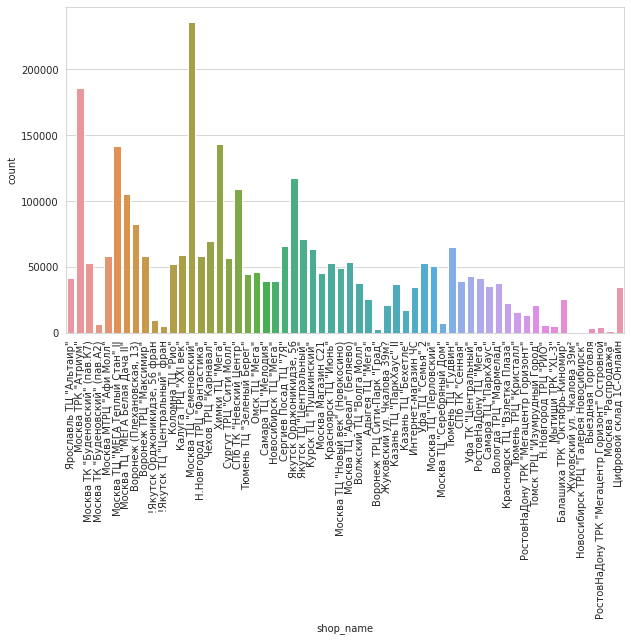

In [27]:
sns.countplot(x='shop_name', data=train_df)
plt.xticks(rotation=90);

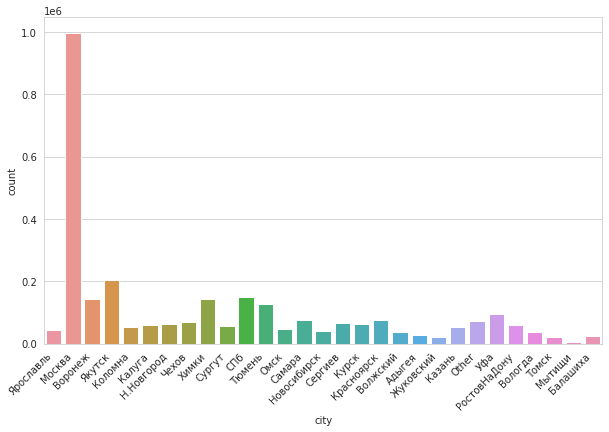

In [28]:
sns.countplot(x='city', data=train_df)
plt.xticks(rotation=45, ha='right');

## Category frequencies

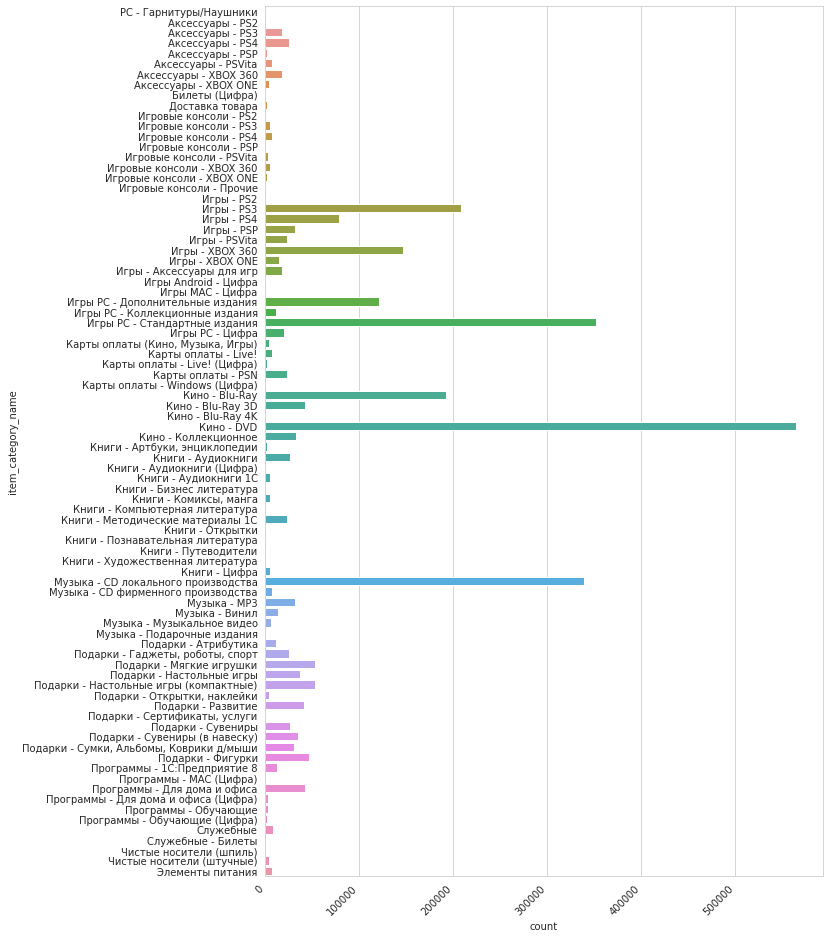

In [29]:
plt.subplots(figsize=(10, 16))
sns.countplot(y=train_df['item_category_name'], order=train_df['item_category_name'].drop_duplicates().sort_values())
plt.xticks(rotation=45, ha='right');

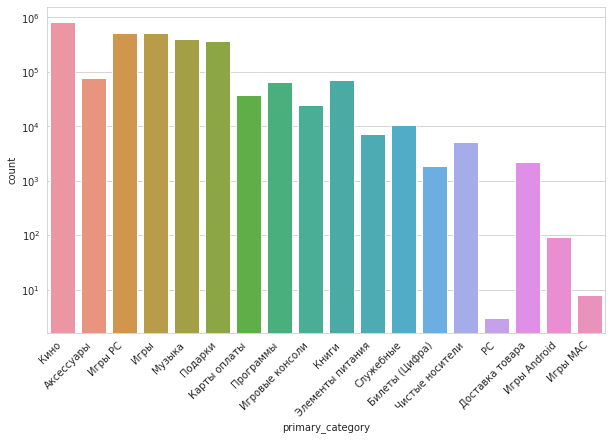

In [30]:
sns.countplot(x='primary_category', data=train_df)
plt.yscale('log')
plt.xticks(rotation=45, ha='right');

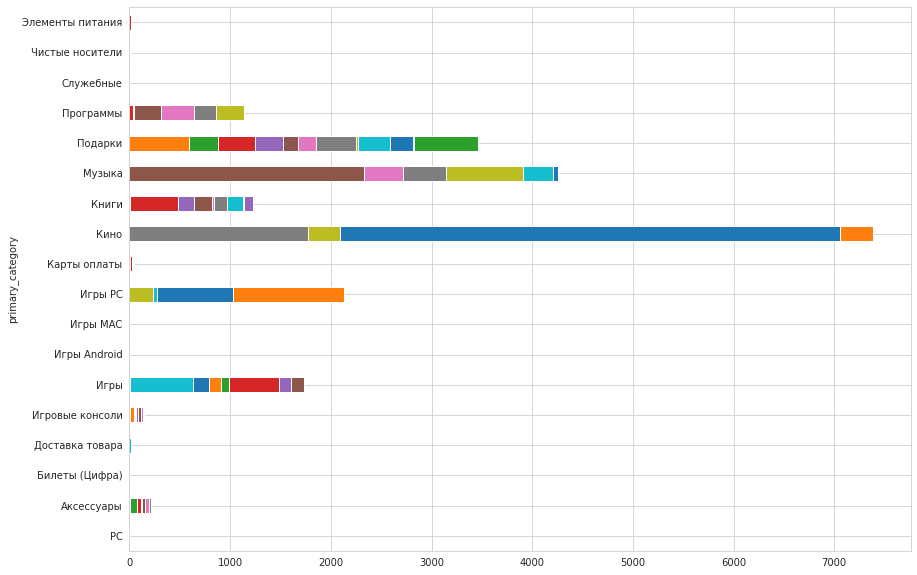

In [31]:
items_in_categories = train_df.groupby(['primary_category', 'item_category_name'])['item_name'].nunique(dropna=False)
items_in_categories.unstack().plot(kind='barh', stacked=True, legend=False, figsize=(14, 10));

In [32]:
items_in_categories.groupby('primary_category').agg(['sum', 'size', 'mean'])

sum  size         mean
primary_category                         
PC                   3     1     3.000000
Аксессуары         217     7    31.000000
Билеты (Цифра)       9     1     9.000000
Доставка товара     12     1    12.000000
Игровые консоли    144     8    18.000000
Игры              1732     8   216.500000
Игры Android         3     1     3.000000
Игры MAC             7     1     7.000000
Игры PC           2129     4   532.250000
Карты оплаты        41     5     8.200000
Кино              7390     5  1478.000000
Книги             1229    13    94.538462
Музыка            4259     6   709.833333
Подарки           3461    12   288.416667
Программы         1133     6   188.833333
Служебные            7     2     3.500000
Чистые носители     15     2     7.500000
Элементы питания    15     1    15.000000

## Time Series Plots

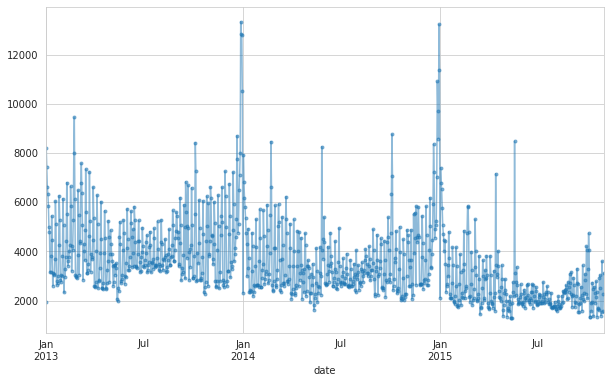

In [33]:
train_df.groupby('date')['item_cnt_day'].sum().plot(marker='.', alpha=0.5);

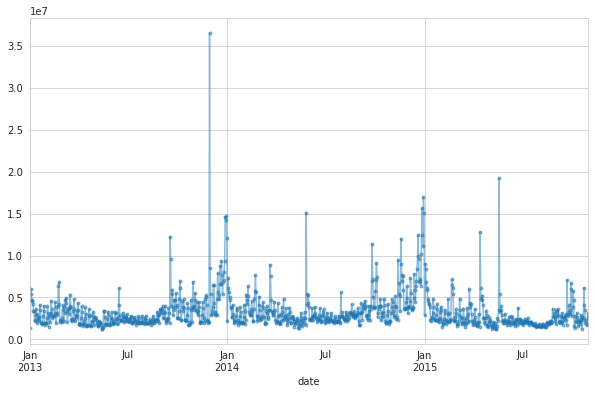

In [34]:
train_df.groupby('date')['revenue'].sum().plot(marker='.', alpha=0.5);

### City/shop over time

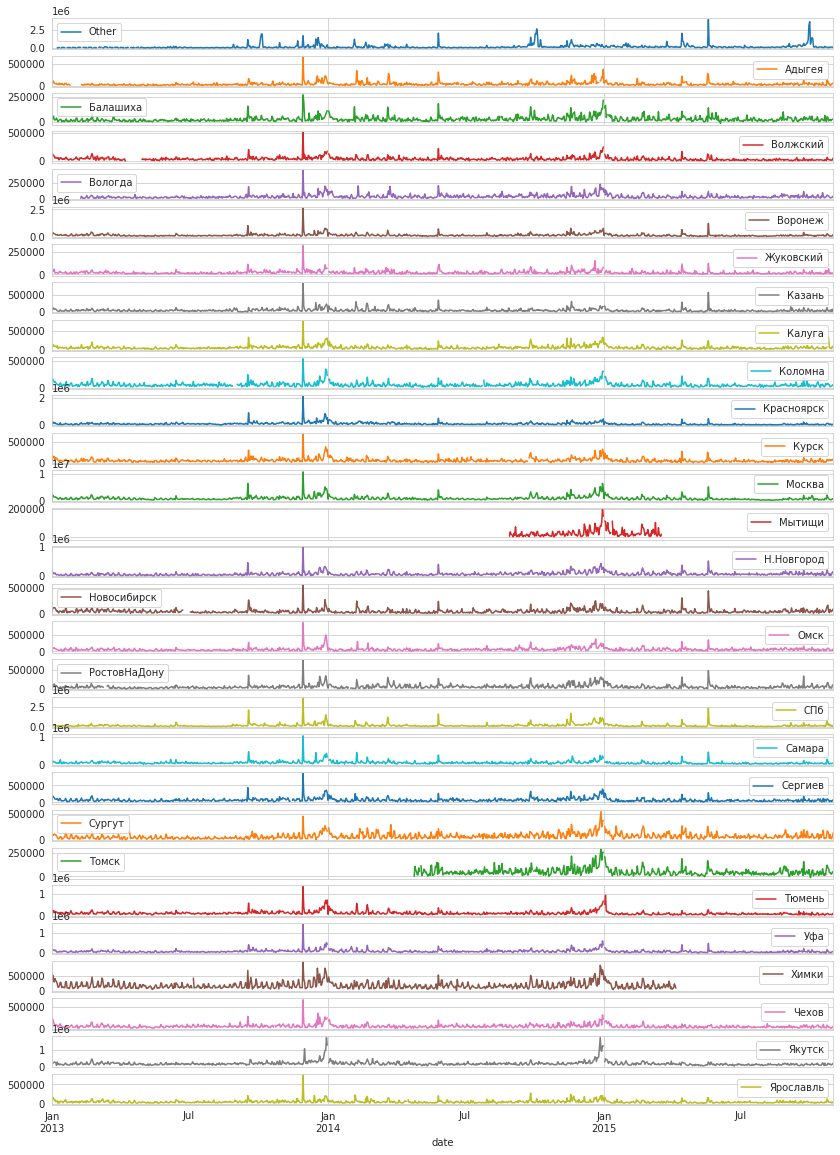

In [35]:
ts_city = train_df.groupby(['date', 'city'])['revenue'].sum().unstack()

rows = len(ts_city.columns)
# plt.subplots(1, rows, figsize=())
ts_city.plot(figsize=(14, 20), subplots=True, sharex=True);

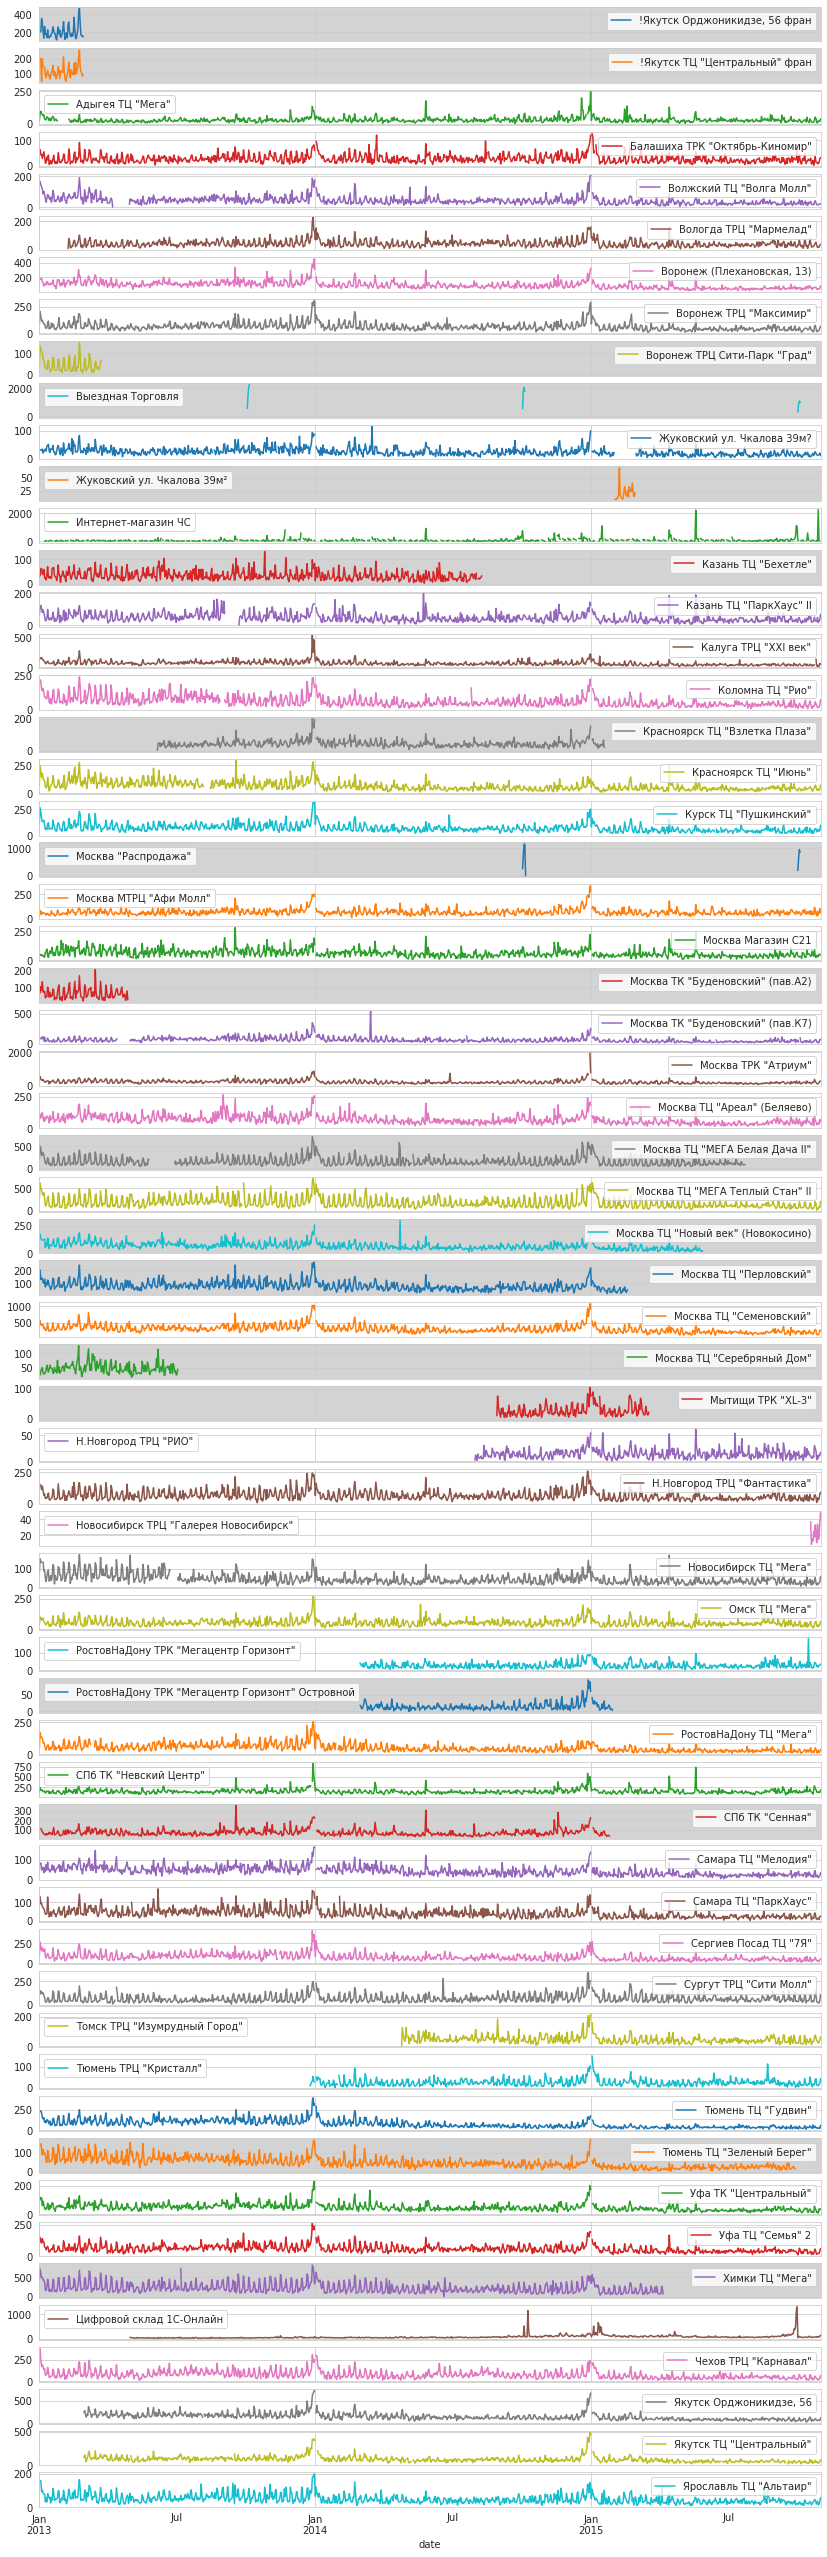

In [36]:
missing_shops = set(np.unique(train_df.shop_name)) - set(np.unique(test_df.shop_name))

ts_shop = train_df.groupby(['date', 'shop_name'])['item_cnt_day'].sum().unstack()
axs = ts_shop.plot(figsize=(14, 46), subplots=True, sharex=True);

for ax in axs[ts_shop.columns.isin(missing_shops)]:
    ax.set_facecolor('lightgrey')

Gray layout color marks shops that do not appear in the test set. They were all closed a while ago

### Category over time

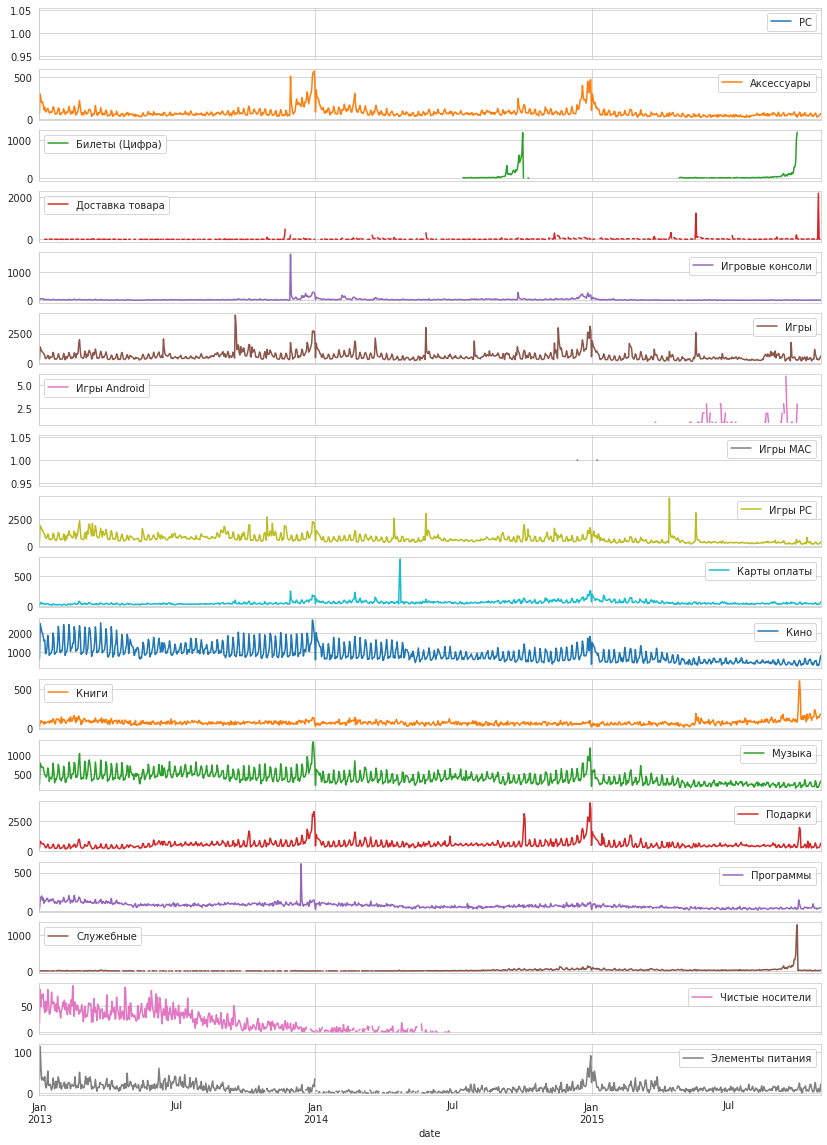

In [37]:
ts_cat = train_df.groupby(['date', 'primary_category'])['item_cnt_day'].sum().unstack()
ts_cat.plot(figsize=(14, 20), subplots=True, sharex=True);

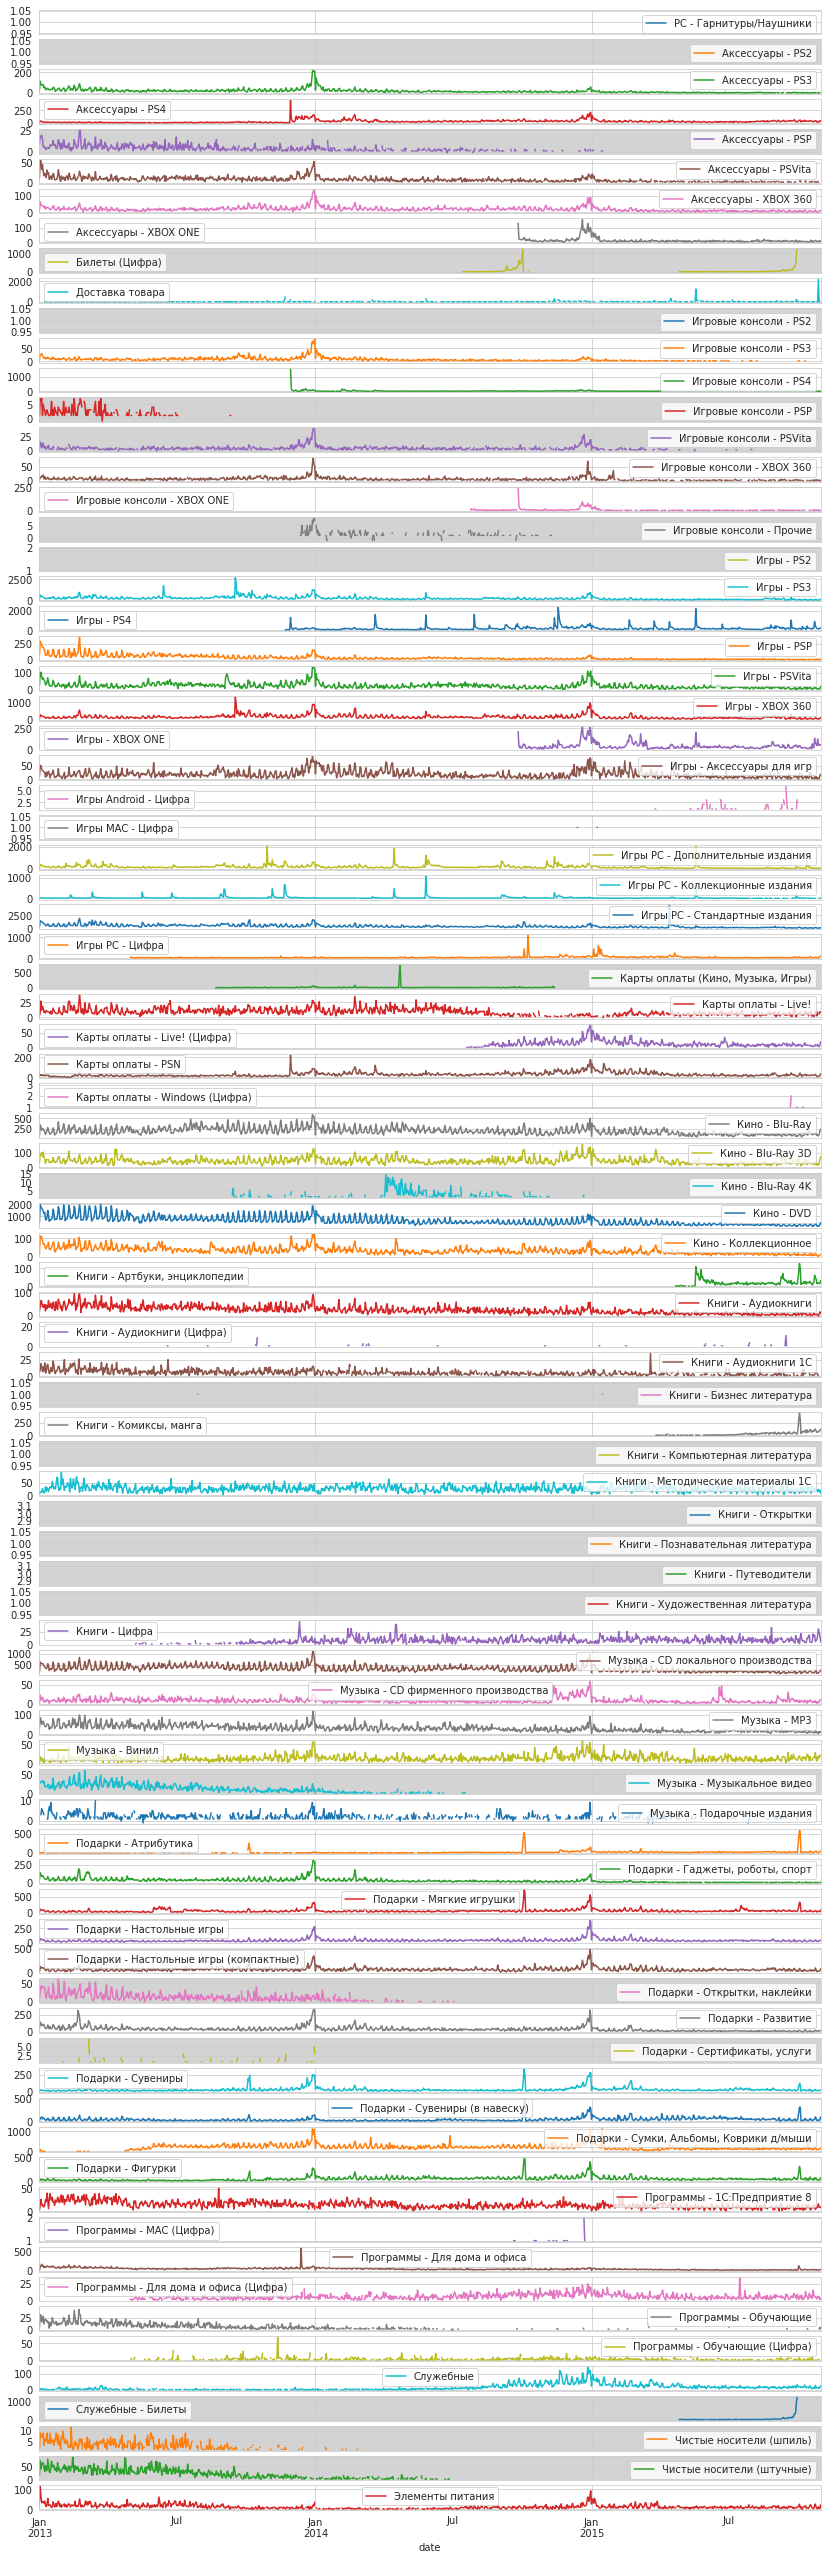

In [38]:
missing_cat = set(np.unique(train_df.item_category_name)) - set(np.unique(test_df.item_category_name))

ts_subcat = train_df.groupby(['date', 'item_category_name'])['item_cnt_day'].sum().unstack()
axs = ts_subcat.plot(figsize=(14, 46), subplots=True, sharex=True);

for ax in axs[ts_subcat.columns.isin(missing_cat)]:
    ax.set_facecolor('lightgrey')

Gray layout color marks categories that do not appear in the test set. Many of them are simply outdated (old game consoles, blank CDs ("Чистые носители", tickets ("Билеты")), other just were unpopular. But there is some categories that have a small number of sales, but still presented in test set: "PC - Гарнитура/Наушники" (earphones), "Игры MAC - Цифра" (Videogames for MAC), and four more ambiguous: "Игры Android - Цифра" (Android games), "Карты оплаты - Windows (цифра)" (payment cards for windows),  "Книги - аудиокниги (цифра)" (digital audiobooks), "Программы - MAC (Цифра)" (software for MAC). Maybe it will be a good idea to set them as 0 manually.

## Shop vs Category

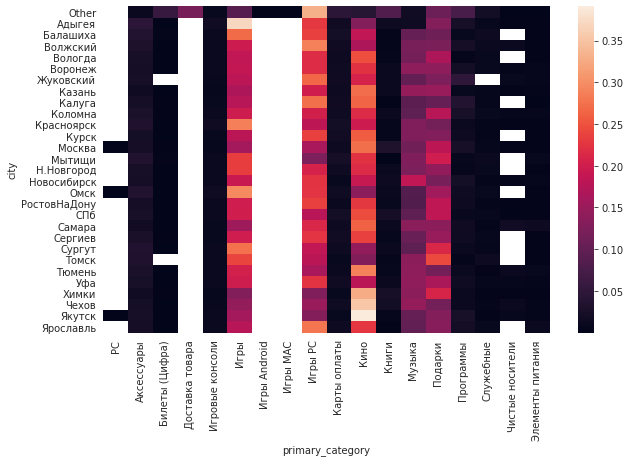

In [39]:
city_vs_category = (train_df.groupby(['city', 'primary_category'])['item_cnt_day']
                            .sum()
                            .unstack()
                            .apply(lambda x: x/x.sum(), axis=1)
                            )
sns.heatmap(city_vs_category, mask=city_vs_category.isna());

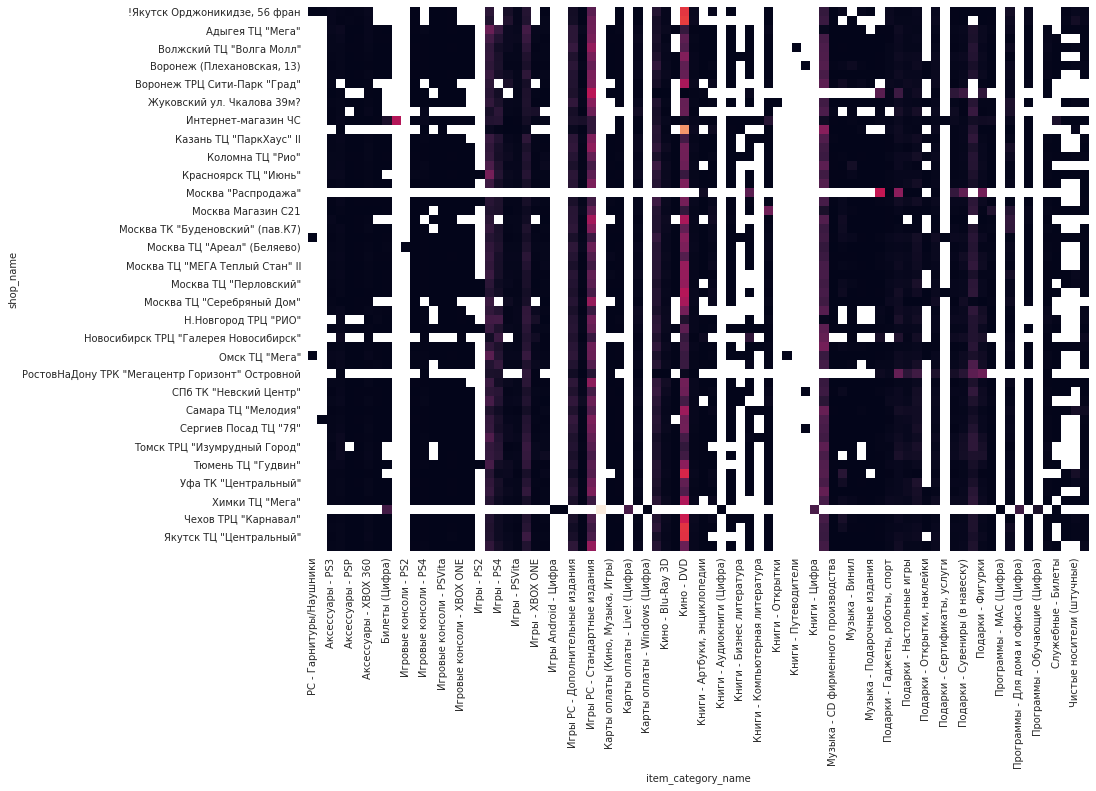

In [40]:
shop_vs_category = (train_df.groupby(['shop_name', 'item_category_name'])['item_cnt_day']
                            .sum()
                            .unstack()
                            .apply(lambda x: x/x.sum(), axis=1)
                            )
plt.subplots(figsize=(14, 10))
sns.heatmap(shop_vs_category, mask=shop_vs_category.isna(), square=False, cbar=False);

## Test data exploration

In [41]:
test_df

ID  shop_id  item_id                              shop_name  \
0            0        5     5037                 Вологда ТРЦ "Мармелад"   
1         5100        4     5037               Волжский ТЦ "Волга Молл"   
2        10200        6     5037             Воронеж (Плехановская, 13)   
3        15300        3     5037         Балашиха ТРК "Октябрь-Киномир"   
4        20400        2     5037                       Адыгея ТЦ "Мега"   
...        ...      ...      ...                                    ...   
214195  193262       46      168                  Сергиев Посад ТЦ "7Я"   
214196  198362       41      168                 РостовНаДону ТЦ "Мега"   
214197  203462       44      168                    Самара ТЦ "Мелодия"   
214198  208562       39      168  РостовНаДону ТРК "Мегацентр Горизонт"   
214199  213662       45      168                   Самара ТЦ "ПаркХаус"   

                city                                          item_name  \
0            Вологда                     NHL 15 [PS3, русские субтитры]   
1           Волжский                     NHL 15 [PS3, русские субтитры]   
2            Воронеж                     NHL 15 [PS3, русские субтитры]   
3           Балашиха                     NHL 15 [PS3, русские субтитры]   
4             Адыгея                     NHL 15 [PS3, русские субтитры]   
...              ...                                                ...   
214195       Сергиев  1С:Аудиокниги. Аудиокурсы по географии. 6 клас...   
214196  РостовНаДону  1С:Аудиокниги. Аудиокурсы по географии. 6 клас...   
214197        Самара  1С:Аудиокниги. Аудиокурсы по географии. 6 клас...   
214198  РостовНаДону  1С:Аудиокниги. Аудиокурсы по географии. 6 клас...   
214199        Самара  1С:Аудиокниги. Аудиокурсы по географии. 6 клас...   

        item_category_id          item_category_name primary_category  
0                     19                  Игры - PS3             Игры  
1                     19                  Игры - PS3             Игры  
2                     19                  Игры - PS3             Игры  
3                     19                  Игры - PS3             Игры  
4                     19                  Игры - PS3             Игры  
...                  ...                         ...              ...  
214195                44  Книги - Аудиокниги (Цифра)            Книги  
214196                44  Книги - Аудиокниги (Цифра)            Книги  
214197                44  Книги - Аудиокниги (Цифра)            Книги  
214198                44  Книги - Аудиокниги (Цифра)            Книги  
214199                44  Книги - Аудиокниги (Цифра)            Книги  

[214200 rows x 9 columns]

In [42]:
columns = test_df.columns[1:]
common = test_df.merge(train_df, on=['shop_id','item_id'])
test_df[(~test_df.shop_id.isin(common.shop_id)) & (~test_df.item_id.isin(common.item_id))]

Empty DataFrame
Columns: [ID, shop_id, item_id, shop_name, city, item_name, item_category_id, item_category_name, primary_category]
Index: []

All the combinations from the test set appearns in the train data

In [43]:
pd.DataFrame({'test': test_df.nunique(), 'train': train_df.nunique()}).dropna()

test    train
city                  27.0     29.0
item_category_id      62.0     84.0
item_category_name    62.0     84.0
item_id             5100.0  21806.0
item_name           5100.0  21806.0
primary_category      16.0     18.0
shop_id               42.0     60.0
shop_name             42.0     60.0

We are predict sales for much less unique items, while numbers of the other categories are almost the same

In [44]:
set(np.unique(train_df.primary_category)) - set(np.unique(test_df.primary_category))

{'Билеты (Цифра)', 'Чистые носители'}

In [45]:
train_df[train_df.primary_category == 'Служебные'].item_name.value_counts()

Прием денежных средств для 1С-Онлайн                              9067
Билет "ИгроМир 2015" - 3 октября 2015 [Цифровая версия]            486
Билет "ИгроМир 2015" - 2 октября 2015 [Цифровая версия]            400
Билет "ИгроМир 2015" - 4 октября 2015 [Цифровая версия]            267
Билет "ИгроМир 2015" - 2 октября 2015 (сайт) [Цифровая версия]      69
Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [Цифровая версия]      61
Билет "ИгроМир 2015" - 4 октября 2015 (сайт) [Цифровая версия]      42
Name: item_name, dtype: int64

In [46]:
test_df[test_df.primary_category == 'Служебные'].item_name.value_counts()

Прием денежных средств для 1С-Онлайн    42
Name: item_name, dtype: int64

In [47]:
missing_cat = set(np.unique(train_df.item_category_name)) - set(np.unique(test_df.item_category_name))
missing_cat

{'Аксессуары - PS2',
 'Аксессуары - PSP',
 'Билеты (Цифра)',
 'Игровые консоли - PS2',
 'Игровые консоли - PSP',
 'Игровые консоли - PSVita',
 'Игровые консоли - Прочие',
 'Игры - PS2',
 'Карты оплаты (Кино, Музыка, Игры)',
 'Кино - Blu-Ray 4K',
 'Книги - Бизнес литература',
 'Книги - Компьютерная литература',
 'Книги - Открытки',
 'Книги - Познавательная литература',
 'Книги - Путеводители',
 'Книги - Художественная литература',
 'Музыка - Музыкальное видео',
 'Подарки - Открытки, наклейки',
 'Подарки - Сертификаты, услуги',
 'Служебные - Билеты',
 'Чистые носители (шпиль)',
 'Чистые носители (штучные)'}

In [48]:
missing_shops = set(np.unique(train_df.shop_name)) - set(np.unique(test_df.shop_name))
missing_shops

{'!Якутск Орджоникидзе, 56 фран',
 '!Якутск ТЦ "Центральный" фран',
 'Воронеж ТРЦ Сити-Парк "Град"',
 'Выездная Торговля',
 'Жуковский ул. Чкалова 39м²',
 'Казань ТЦ "Бехетле"',
 'Красноярск ТЦ "Взлетка Плаза"',
 'Москва "Распродажа"',
 'Москва ТК "Буденовский" (пав.А2)',
 'Москва ТЦ "МЕГА Белая Дача II"',
 'Москва ТЦ "Новый век" (Новокосино)',
 'Москва ТЦ "Перловский"',
 'Москва ТЦ "Серебряный Дом"',
 'Мытищи ТРК "XL-3"',
 'РостовНаДону ТРК "Мегацентр Горизонт" Островной',
 'СПб ТК "Сенная"',
 'Тюмень ТЦ "Зеленый Берег"',
 'Химки ТЦ "Мега"'}

We've seen these train-only categories on the plots earlier.